## Counting steels by morphology

### Requirement

> * Programming for steel bar counting based on morphological image processing
> * The objective evaluation is Precision & Recall.
> * Try to make your objective evaluation value higher.

> * 召回率（recall）：是针对我们原来样本而言，表示有多少样本中的正例（一种是把正类预测为正类即TP，一种是把正类预测为负类即FN）被预测正确了。
> * 召回率（recall） = 提取出的正确信息条数 / 样本中的信息条数。



连通分量的个数:245
Recall of the result: 1.1722488038277512


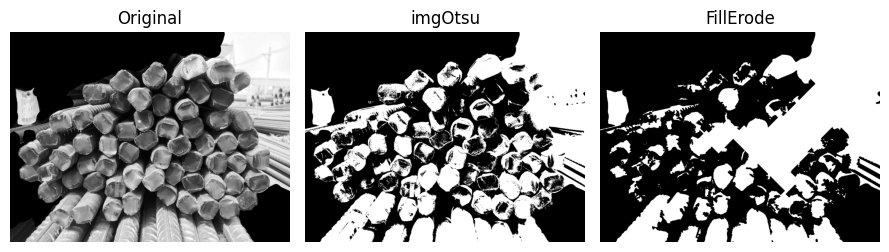

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread("data/1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


imgGray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
imgGray=cv2.equalizeHist(imgGray)



## 预处理，组合滤波，先中值后高斯（可修改）
# 自适应滤波器
# imgGray = adaptMeadianFilter(img,3,300)
imgGray=cv2.GaussianBlur(imgGray,(1,1),0.25)
imgGray=cv2.medianBlur(imgGray,1)

histCV = cv2.calcHist([imgGray], [0], None, [256], [0, 256])  # 灰度直方图
scale = range(256)  # 灰度级 [0,255]
totalPixels = imgGray.shape[0] * imgGray.shape[1]  # 像素总数
totalGray = np.dot(histCV[:,0], scale)  # 内积, 总和灰度值
mG = totalGray / totalPixels  # 平均灰度
icv = np.zeros(256)
numFt, sumFt = 0, 0
for t in range(256):  # 遍历灰度值
    numFt += histCV[t,0]   # F(t) 像素数量
    sumFt += histCV[t,0] * t  # F(t) 灰度值总和
    pF = numFt / totalPixels  # F(t) 像素数占比
    mF = (sumFt/numFt) if numFt>0 else 0  # F(t) 平均灰度
    numBt = totalPixels-numFt  # B(t) 像素数量
    sumBt = totalGray - sumFt  # B(t) 灰度值总和
    pB = numBt / totalPixels  # B(t) 像素数占比
    mB = (sumBt/numBt) if numBt>0 else 0  # B(t) 平均灰度
    icv[t] = pF * (mF-mG)**2 + pB * (mB-mG)**2  # 灰度 t 的类间方差

ret, imgOtsu = cv2.threshold(imgGray, mG, 255, cv2.THRESH_OTSU)

## 形态学操作（可修改）
se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
se7 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
se5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
se9 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
se13 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))


erosion1 = cv2.erode(imgOtsu,se1,iterations = 1)
opening1 = cv2.morphologyEx(erosion1, cv2.MORPH_OPEN, kernel=se1,iterations =2)
erosion = cv2.erode(opening1,se13,iterations =1)



## 孔洞填充
inverseB=cv2.bitwise_not(erosion)
#构造3×3十字形
kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# 构建阵列F，写入imgInv得的边界值
F=np.zeros(inverseB.shape,np.uint8)
F[:,0]=inverseB[:,0]
F[:,-1]=inverseB[:,-1]
F[0,:]=inverseB[0,:1]
F[-1,:]=inverseB[-1,:]
## 循环迭代：
Flast=F.copy()
for i in range(1000):
    F_dilation=cv2.dilate(F,kernel)
    F=cv2.bitwise_and(F_dilation,inverseB)
    if(F==Flast).all():
        break
    else:
        Flast=F.copy()
FillErode=cv2.bitwise_not(F)

## 连通分量提取
FillErodeCopy=FillErode.copy()

X=np.zeros(FillErode.shape,dtype=np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
count = []
## 循环迭代，直到 FillErodeCopy 中的像素值全部为0
while FillErodeCopy.any():
    Xa_copy,Ya_copy=np.where(FillErodeCopy > 0)
    X[Xa_copy[0]][Ya_copy[0]] = 255
    # 约束膨胀，先对X膨胀,再对FillErode执行与操作
    for i in range(100):
        dilation_X=cv2.dilate(X,kernel)
        X=cv2.bitwise_and(dilation_X,FillErode)

    Xb,Yb=np.where(X>0)
    FillErodeCopy[Xb,Yb]=0
    # 显示连通分量及其包含像素数量
    count.append(len(Xb))
print("连通分量的个数:{}".format(len(count)))
print("Recall of the result: {}".format(len(count)/209))


# display
plt.figure(figsize=(9, 6))
images=[imgGray,imgOtsu,FillErode]
titles=["Original","imgOtsu","FillErode"]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i],"gray")
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()